In [1]:
import numpy as np
import time
import pickle as pk

# Declarando constantes

In [12]:
h = 0.01
k = 0.01
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5
X_nb = 1e-4
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))
size_y = int(((y_dom[1] - y_dom[0]) / (h)))
size_tt = int(((t_dom[1] - t_dom[0]) / (k)))


print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_tt,
        size_x,
        size_y,
    )
)

CFL = (Db * k) / ((2 * (h * h)))

print("CFL: ", CFL)
if CFL >= 1:
    print("Criterio não satisfeito")

Size x = 100, y = 100 
 
Steps in time = 1000
Steps in space_x = 100
Steps in space_y = 100

CFL:  0.005000000000000001


In [13]:
struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__Db--"
    + str(Db)
    + "__Dn--"
    + str(Dn)
    + "__phi--"
    + str(phi)
    + "__ksi--"
    + str(ksi)
    + "__cb--"
    + str(cb)
    + "__lambd_nb--"
    + str(lambd_nb)
    + "__mi_n--"
    + str(mi_n)
    + "__lambd_bn--"
    + str(lambd_bn)
    + "__y_n--"
    + str(y_n)
    + "__Cn_max--"
    + str(Cn_max)
    + "__X_nb--"
    + str(Cn_max)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)

print("struct_name: ", struct_name)

struct_name:  h--0.01__k--0.01__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.5__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


# Versão Serial

In [14]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
def fb(Cb, Cn, i, j):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
def fn(Cb, Cn, i, j):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j])
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


def fx_Cb_right(Cb, i, j):
    return 0 if i == size_x - 1 else (Cb[i + 1, j] - Cb[i, j])


def fx_Cb_left(Cb, i, j):
    return 0 if i == 0 else (Cb[i, j] - Cb[i - 1, j])


def fx_Cb_up(Cb, i, j):
    return 0 if i == size_y - 1 else (Cb[i, j + 1] - Cb[i, j])


def fx_Cb_down(Cb, i, j):
    return 0 if i == 0 else (Cb[i, j] - Cb[i, j - 1])


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
def apply_initial_conditions(Cb, tam_max):
    # Para uma região central do domínio, define uma concentração inicial de bactérias
    for i in range(tam_max):
        for j in range(tam_max):
            if (i * h >= 0.4) and (i * h) <= 0.6:
                if (j * h >= 0.4) and (j * h) <= 0.6:
                    Cb[i][j] = 0.2

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
def solve_pde():
    # Definindo o tamanho das malhas (discretização espacial e temporal)
    size_x = int(((x_dom[1] - x_dom[0]) / (h)) + 1)
    size_y = int(((y_dom[1] - y_dom[0]) / (h)) + 1)
    size_tt = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)
    Cn_new = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cn_final = np.zeros((size_tt, size_x, size_y))
    Cb_final = np.zeros((size_tt, size_x, size_y))

    # Aplicando condições iniciais para a concentração de bactérias
    Cb_new = apply_initial_conditions(Cb_new, size_x)

    # Armazenando as condições iniciais
    Cb_final[0] = Cb_new
    Cn_final[0] = Cn_new

    # Loop sobre o tempo
    for time in range(1, size_tt):
        # Atualizando as concentrações anteriores (passo temporal anterior)
        Cn_old = Cn_new.copy()
        Cb_old = Cb_new.copy()

        # Loop sobre o espaço (malha espacial)
        for i in range(size_x):

            for j in range(size_y):

                fx_Cb_right = (
                    0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])
                )

                fx_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

                fx_Cb_up = 0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])

                fx_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

                # Atualizando as concentrações de bactérias
                Cb_new[i][j] = (
                    (k * Db)
                    / (h * h * phi)
                    * (fx_Cb_right * fx_Cb_right - fx_Cb_left + fx_Cb_up - fx_Cb_down)
                    + (k / phi) * fb(Cb_old, Cn_old, i, j)
                    + Cb_old[i, j]
                )

                fx_Cn_right = (
                    0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))
                )

                fx_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

                fx_Cn_up = 0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))

                fx_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

                adv_right = (
                    0
                    if i == size_x - 1
                    else (
                        (Cn_old[i, j] * fx_Cb_right)
                        if fx_Cb_right > 0
                        else (Cn_old[i + 1, j] * fx_Cb_right)
                    )
                )

                adv_left = (
                    0
                    if i == 0
                    else (
                        (Cn_old[i, j] * fx_Cb_left)
                        if fx_Cb_left > 0
                        else (Cn_old[i - 1, j] * fx_Cb_left)
                    )
                )

                adv_up = (
                    0
                    if j == size_y - 1
                    else (
                        (Cn_old[i, j] * fx_Cb_up)
                        if fx_Cb_up > 0
                        else (Cn_old[i, j + 1] * fx_Cb_up)
                    )
                )

                adv_down = (
                    0
                    if j == 0
                    else (
                        (Cn_old[i, j] * fx_Cb_down)
                        if fx_Cb_down > 0
                        else (Cn_old[i, j - 1] * fx_Cb_down)
                    )
                )

                # Atualizando as concentrações de neutrófilos
                Cn_new[i][j] = (
                    (k * Dn)
                    / (h * h * phi)
                    * (fx_Cn_right - fx_Cn_left + fx_Cn_up - fx_Cn_down)
                    - (X_nb * k)
                    / (h * h * phi)
                    * (adv_right - adv_left + adv_up - adv_down)
                    + (k / phi) * fn(Cb_old, Cn_old, i, j)
                    + Cn_old[i, j]
                )

                # Armazenando os resultados para o passo de tempo atual
                Cb_final[time][i][j] = Cb_new[i][j]
                Cn_final[time][i][j] = Cn_new[i][j]

    # Retornando as matrizes finais de concentração de bactérias e neutrófilos ao
    # longo do tempo
    return Cb_final, Cn_final

In [16]:
Cb, Cn = solve_pde()

with open("fdm_sim/Cp__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cb, f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "wb") as f:
    pk.dump(Cn, f)

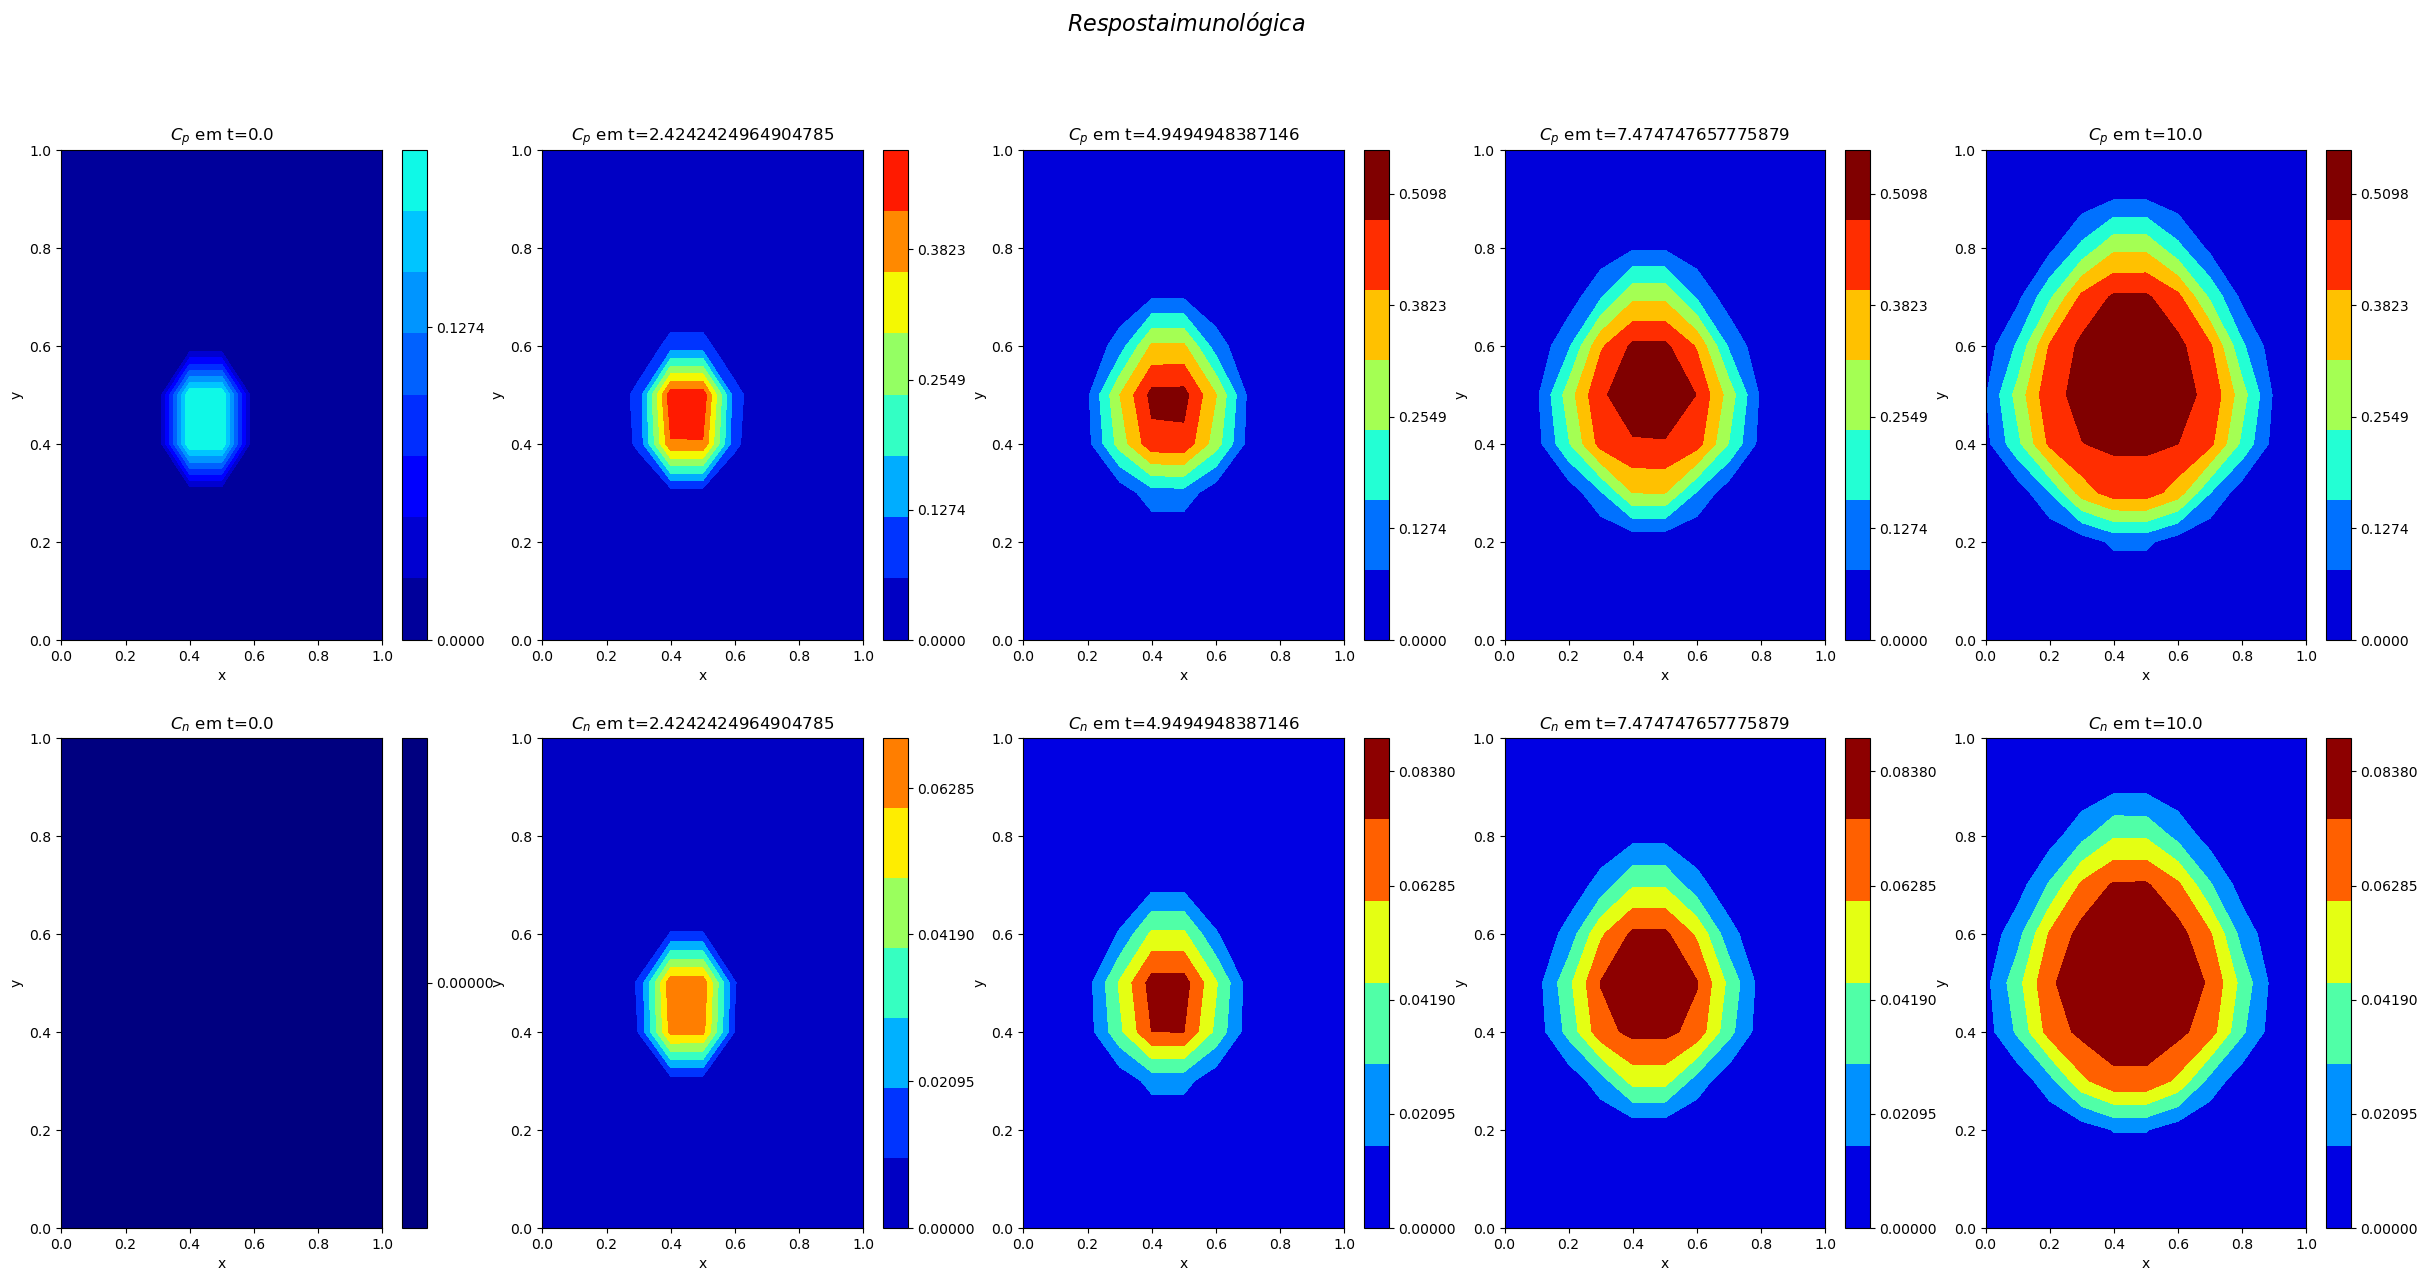

In [ ]:
import matplotlib.pyplot as plt

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_tt, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x+1, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y+1, endpoint=True, dtype=np.float32)


X, Y = np.meshgrid(
    x_np,
    y_np,
)

time_plot = np.linspace(0, size_tt - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cb)
    vmax = np.max(Cb)

    contour = ax.contourf(
        X,
        Y,
        Cb[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cn)
    vmax = np.max(Cn)

    contour = ax.contourf(
        X,
        Y,
        Cn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

# Versão paralela